This Excercise will Cover these steps 

### Scorecard Development Plan ####
Understand the Data and develop a POC Credit Scorecard which Business can use to Accept or Reject Customer based upon Probablity of Default (PD) 

  ##### PART 1 Data Preparation and Exporatory Data Analysis

  * Data Prepartion Compilation of All Dataframes into single dataframe. 
  * Target Defination of Customer i.e. GBFlag_cus
  * SQL Query compilation of final dataframe and outlier detection
  * Initial Analysis of Customer Segments 
  * Calculation of cummulative default rate wrt to Loan Amount 

 ##### PART 2 Feature Engineering
  * Mapping with English Translation of atttributes
  * Handling NaN, negative and Outliers. 
  * Cross variables
  * GB Ratios
  * Characteristics Analysis Report
    * Fine Classing 
    * Coarse Classing 
    * Information value 
    * WoE transformations 
    * Univariate Analysis/ Feature Selection
    * Feature Distribution across Target Defination

 ##### PART 3 Scorecard Development
  * Variable Selection
  * Model Selection


##### PART 4 Cut off strategy
   * Cut-off Analysis
   * Risk Analysis  
   * Profitability Analysis 
      * Cost Analysis: 
        * Dependecies (Unit Economics): 
          - overheads & variable cost
   * Probability of defaults Distribution (PDs)

In [3]:
import sys

if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    import collections
    setattr(collections, "MutableMapping", collections.abc.MutableMapping)

In [4]:
import numpy as np
import pandas as pd
import sqlalchemy as sa
path = 'data/'

In [5]:
 # Create SQL Alchemy Engine
engine = sa.create_engine('sqlite:///database.db')

In [6]:
# Import data as pd.DataFrame
application_df = pd.read_csv(path + 'application.csv')
loan_df = pd.read_csv(path + 'loan.csv')
payment1_df = pd.read_csv(path + 'payment1.csv')
payment2_df = pd.read_csv(path + 'payment2.csv')

In [7]:
# Insert data from pd.DataFrame to SQL Alchemy Engine
application_df.to_sql(name='application', con=engine,if_exists='replace')
loan_df.to_sql(name='loan', con=engine,if_exists='replace')
payment1_df.to_sql(name='payment1', con=engine,if_exists='replace')
payment2_df.to_sql(name='payment2', con=engine,if_exists='replace')

17911

In [8]:
def query_from_db(sql_long_string, engine):
    """
    Execute SQL Statement and return the queried data as a pandas.DataFrame object

    :param sql_long_string: SQL statement
    :param engine: SQL Alchemy engine
    """
    statement = engine.execute(sql_long_string)
    df = pd.DataFrame(statement.fetchall())
    df.columns = statement.keys()
    return df

  ##### PART 1 Data Preparation and Exporatory Data Analysis


Target to is compile one final dataset includes all Application, Repayment and Drived Variables which will be part of the Feature Engineering part and Modleing Process. The final result of the dataset will be one row that will define everything related to customer. 

*application_df*: Contains all customer's application data

*loan_df*: Contains all the loans taken by customer

*paymnent_df*: Contains repayment behavior of loans taken by customer.


#### Drived Variables 

Variables Drived from payment_df:
1.  Minimum Loan Amount taken 
2.  Maximum Loan Amount takne
3.  Average Loan Amount taken
4.  Total Defaulted Loans
5.  Total Amount Disbursed
6.  Total Amount Recovered
7.  Recovery Rate
8.  Good/Bad Flag per Loan

Variables Drived from loan_df:
1.  Total Loans taken by customer
2.  Maximum DPD 
3.  Good/Bad Flag per customer

Variables Drived from payment_df:
1. Age 




* Note: Feature extraction part is covered in the same query


In [9]:
query = """
WITH CleanedLoanData AS (
    SELECT
        CAST(COALESCE(loan_id, 0) AS TEXT) AS loan_id,
        CAST(CAST(COALESCE(application_id, 0) AS INTEGER) AS TEXT) AS application_id_str,
        CASE
            WHEN fund_transfer_ts IS NOT NULL THEN DATE(fund_transfer_ts)
            ELSE NULL
        END AS DisbursementDate,
        loan_amount,
        loan_duration,
        installment_amount
    FROM loan
    WHERE application_id IS NOT NULL AND application_id != 0
),
DateFormattedLoanData AS (
    SELECT
        loan_id,
        application_id_str,
        DisbursementDate,
        strftime('%m-%Y', DisbursementDate) AS Disb_Month,
        ROW_NUMBER() OVER (PARTITION BY application_id_str ORDER BY DisbursementDate) AS loan_num,
        COUNT(*) OVER (PARTITION BY application_id_str) AS total_loans,
        loan_amount,
        loan_duration,
        installment_amount
    FROM CleanedLoanData
),
AggregatedPayments AS (
    SELECT
        CAST(COALESCE(loan_id, 0) AS TEXT) AS loan_id,
        MAX(CASE 
            WHEN dpd IS NULL AND due_date IS NOT NULL THEN (julianday('now') - julianday(due_date))
            ELSE dpd 
        END) AS max_dpd,
        SUM(paid_amount) AS total_paid_amount,
        CASE 
            WHEN COUNT(CASE WHEN paid_amount > 0 THEN 1 END) = 0 THEN 'Bad' 
            ELSE 'Good'
        END AS GBFlag
    FROM payment1
    GROUP BY loan_id
),
LoanAmountStats AS (
    SELECT
        CAST(CAST(COALESCE(application_id, 0) AS INTEGER) AS TEXT) AS application_id_str,
        MIN(loan_amount) AS Min_Loan_Amount,
        MAX(loan_amount) AS Max_Loan_Amount,
        AVG(loan_amount) AS Avg_Loan_Amount
    FROM loan
    GROUP BY application_id_str
),
DefaultedLoans AS (
    SELECT
        CAST(CAST(COALESCE(application_id, 0) AS INTEGER) AS TEXT) AS application_id_str,
        COUNT(*) AS Defaulted_Loans
    FROM loan
    WHERE loan_id IN (
        SELECT loan_id
        FROM AggregatedPayments
        WHERE total_paid_amount = 0
    )
    GROUP BY application_id_str
),
LoanAndPaymentMerged AS (
    SELECT
        D.*,
        A.max_dpd AS dpd_calculated_max,
        A.total_paid_amount AS recovered_amount,
        A.GBFlag
    FROM DateFormattedLoanData D
    LEFT JOIN AggregatedPayments A ON D.loan_id = A.loan_id
),
AggregatedTotals AS (
    SELECT
        application_id_str,
        SUM(loan_amount) AS Total_Amount_Disbursed,
        SUM(recovered_amount) AS Total_Amount_Recovered,
        (SUM(recovered_amount) / SUM(loan_amount)) * 100 AS Recovery_Rate
    FROM LoanAndPaymentMerged
    GROUP BY application_id_str
),
GBFlagCustomer AS (
    SELECT
        application_id_str,
        CASE 
            WHEN SUM(CASE WHEN GBFlag = 'Bad' THEN 1 ELSE 0 END) > 0 THEN 'Bad'
            ELSE 'Good'
        END AS GBFlag_cus
    FROM LoanAndPaymentMerged
    GROUP BY application_id_str
),
ApplicationWithAge AS (
    SELECT
        CAST(CAST(COALESCE(application_id, 0) AS INTEGER) AS TEXT) AS application_id,
        CAST(COALESCE(customer_id, 0) AS TEXT) AS customer_id_str,
        dob,
        (strftime('%Y', 'now') - strftime('%Y', dob)) - 
        (strftime('%m-%d', 'now') < strftime('%m-%d', dob)) AS Age,
        loan_purpose,
        loan_purpose_desc,
        address_provinsi,
        marital_status,
        dependent,
        job_type,
        job_industry
    FROM application
),
FinalMergedData AS (
    SELECT
        LPM.*,
        LAS.Min_Loan_Amount,
        LAS.Max_Loan_Amount,
        LAS.Avg_Loan_Amount,
        COALESCE(DL.Defaulted_Loans, 0) AS Defaulted_Loans,
        AT.Total_Amount_Disbursed,
        AT.Total_Amount_Recovered,
        AT.Recovery_Rate,
        GC.GBFlag_cus
    FROM LoanAndPaymentMerged LPM
    INNER JOIN AggregatedTotals AT ON LPM.application_id_str = AT.application_id_str
    INNER JOIN GBFlagCustomer GC ON LPM.application_id_str = GC.application_id_str
    LEFT JOIN LoanAmountStats LAS ON LPM.application_id_str = LAS.application_id_str
    LEFT JOIN DefaultedLoans DL ON LPM.application_id_str = DL.application_id_str
),
CustomerProfile AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY application_id ORDER BY application_id) AS rn
    FROM (
        SELECT
            AWA.application_id,
            AWA.customer_id_str,
            AWA.dob,
            AWA.Age,
            AWA.loan_purpose,
            AWA.loan_purpose_desc,
            AWA.address_provinsi,
            AWA.marital_status,
            AWA.dependent,
            AWA.job_type,
            AWA.job_industry,
            FMD.loan_id,
            FMD.Disb_Month,
            FMD.loan_amount,
            FMD.recovered_amount,
            FMD.loan_duration,
            FMD.installment_amount,
            FMD.loan_num,
            FMD.total_loans,
            FMD.dpd_calculated_max,
            FMD.GBFlag,
            FMD.Min_Loan_Amount,
            FMD.Max_Loan_Amount,
            FMD.Avg_Loan_Amount,
            FMD.Defaulted_Loans,
            FMD.Total_Amount_Disbursed,
            FMD.Total_Amount_Recovered,
            FMD.Recovery_Rate,
            FMD.GBFlag_cus
        FROM ApplicationWithAge AWA
        LEFT JOIN FinalMergedData FMD ON AWA.application_id = FMD.application_id_str
    ) AS subquery
)
SELECT
    application_id,
    customer_id_str,
    dob,
    Age,
    loan_purpose,
    loan_purpose_desc,
    address_provinsi,
    marital_status,
    dependent,
    job_type,
    job_industry,
    loan_id,
    Disb_Month,
    loan_amount,
    recovered_amount,
    loan_duration,
    installment_amount,
    loan_num,
    total_loans,
    dpd_calculated_max,
    GBFlag,
    Min_Loan_Amount,
    Max_Loan_Amount,
    Avg_Loan_Amount,
    Defaulted_Loans,
    Total_Amount_Disbursed,
    Total_Amount_Recovered,
    Recovery_Rate,
    GBFlag_cus
FROM CustomerProfile
WHERE rn = 1
ORDER BY application_id;



""" 
combined_data = pd.read_sql_query(query, engine)


In [10]:
combined_data

,application_id,customer_id_str,dob,Age,loan_purpose,loan_purpose_desc,address_provinsi,marital_status,dependent,job_type,...,dpd_calculated_max,GBFlag,Min_Loan_Amount,Max_Loan_Amount,Avg_Loan_Amount,Defaulted_Loans,Total_Amount_Disbursed,Total_Amount_Recovered,Recovery_Rate,GBFlag_cus
0,2004025560801,2003023491027.0,1984-04-18,39.0,Modal usaha,memulai usaha online berjualan masker online,Dki Jakarta,Menikah,1.0,None,...,30.0,Good,800000.0,6000000.0,2.200000e+06,0.0,8800000.0,16484000.0,187.318182,Good
1,2004025574618,2003022578685.0,1993-12-19,30.0,Renovasi Rumah,tujuan untuk renovasi rumah dan lain lain,DKI Jakarta,Lajang,0.0,Pegawai swasta,...,30.0,Good,500000.0,2500000.0,1.875000e+06,0.0,7500000.0,5784000.0,77.120000,Good
2,2004025576523,2003023497984.0,1986-06-08,37.0,None,untuk menambah modal untuk divisi baru cargo,Jawa Timur,Menikah,3.0,Pengusaha,...,28.0,Good,500000.0,2000000.0,1.333333e+06,0.0,8000000.0,8256000.0,103.200000,Good
3,2004025579060,2003022540354.0,1987-10-01,36.0,Biaya kesehatan,untuk membantu saya dalam kendala biaya keseha...,DKI Jakarta,Menikah,1.0,Pegawai swasta,...,28.0,Good,300000.0,4000000.0,1.088889e+06,0.0,9800000.0,8900000.0,90.816327,Good
4,2004025589544,2003023503682.0,1991-08-27,32.0,Modal usaha,modal usaha roti bakar dan cireng isi pisang k...,None,Menikah,0.0,Pegawai swasta,...,30.0,Good,500000.0,2000000.0,8.750000e+05,1.0,3500000.0,1566000.0,44.742857,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,2004028342683,0,None,NaN,Renovasi Rumah,Nambah ruangan kamar utk anak yg sudah beranja...,Sumatera Utara,Menikah,3.0,Pegawai swasta,...,30.0,Good,10000000.0,10000000.0,1.000000e+07,0.0,10000000.0,4552000.0,45.520000,Good
493,2004028361801,2003024691990.0,1972-12-04,51.0,Modal usaha,Buat modal dagang di pasar Gembrong lama,DKI Jakarta,Menikah,2.0,Freelance,...,1.0,Good,300000.0,300000.0,3.000000e+05,0.0,1200000.0,1354000.0,112.833333,Good
494,2004028366894,2003025166136.0,1987-04-04,36.0,Modal usaha,modal usaha jskskksks jsjkskkk. jsksksk.,Jawa Barat,Menikah,3.0,Pengusaha,...,29.0,Good,2000000.0,2000000.0,2.000000e+06,0.0,2000000.0,1130000.0,56.500000,Good
495,2004028394307,2003021691417.0,1988-03-17,35.0,None,saya ingin menambah barang dagangan sehingga u...,Banten,Menikah,3.0,Pegawai swasta,...,74.0,Good,300000.0,9500000.0,2.046692e+06,4.0,14326842.0,88547477.0,618.053001,Bad


In [11]:
combined_data.columns

Index(['application_id', 'customer_id_str', 'dob', 'Age', 'loan_purpose',
       'loan_purpose_desc', 'address_provinsi', 'marital_status', 'dependent',
       'job_type', 'job_industry', 'loan_id', 'Disb_Month', 'loan_amount',
       'recovered_amount', 'loan_duration', 'installment_amount', 'loan_num',
       'total_loans', 'dpd_calculated_max', 'GBFlag', 'Min_Loan_Amount',
       'Max_Loan_Amount', 'Avg_Loan_Amount', 'Defaulted_Loans',
       'Total_Amount_Disbursed', 'Total_Amount_Recovered', 'Recovery_Rate',
       'GBFlag_cus'],
      dtype='object')

In [12]:
print(combined_data['GBFlag_cus'].value_counts()) 

GBFlag_cus
Good    258
Bad     238
Name: count, dtype: int64


In [13]:
combined_data.to_excel('customer_profile_sql.xlsx')

In [14]:
print(list(combined_data.columns) ) 

['application_id', 'customer_id_str', 'dob', 'Age', 'loan_purpose', 'loan_purpose_desc', 'address_provinsi', 'marital_status', 'dependent', 'job_type', 'job_industry', 'loan_id', 'Disb_Month', 'loan_amount', 'recovered_amount', 'loan_duration', 'installment_amount', 'loan_num', 'total_loans', 'dpd_calculated_max', 'GBFlag', 'Min_Loan_Amount', 'Max_Loan_Amount', 'Avg_Loan_Amount', 'Defaulted_Loans', 'Total_Amount_Disbursed', 'Total_Amount_Recovered', 'Recovery_Rate', 'GBFlag_cus']


***Outlier Management and Identification***

All missing values in the dataset have been successfully replaced with -999, ensuring there are no NaN values remaining across all columns. This approach has standardized the handling of missing data for this analysis, making the dataset ready for further processing or analysis steps without concerns about missing data affecting the results.

We will handle NaN and any outlier in Fine and Coarse Classing as well in Feature Engineering part

In [15]:
combined_data = combined_data.fillna(-999)

In [16]:
combined_data.to_sql(name='customer_profile', con=engine,if_exists='replace')

497

**Handling Outliers:**

For each of these variables with outliers, the method of handling will depend on the context of the analysis and the nature of the outliers. Common strategies include:

In credit scorecarding we dont remove Nulls or any outliers without discussing with Portfolio Managers or Product Manager. NaNs have some meaning while filling applicaiton sometimes Customers dont know exactly what to choose he tend to leave that form unless deemed mandatory.

Similarly for Outliers, if there is an Age outlier which should not be there, e.g. Suppose if we are NOT disbursing above age 50 and there is a customer who have got a loan with Age 51, means we need to inform this to Policy Guys to investigate this issue. 

To Handle the outliers, in scorecarding we do that in coarse classing where we bin the variable attributes that includes both NaNs and outliers.


In [17]:
# Define your columns
columns = ['Age', 'dependent', 'loan_amount', 'loan_duration', 'total_loans', 'dpd_calculated_max', 'Total_Amount_Disbursed', 'Total_Amount_Recovered', 'Recovery_Rate']

outlier_counts = {}

for col in columns:
    query = f"""
    WITH Sorted AS (
        SELECT
            {col},
            ROW_NUMBER() OVER (ORDER BY {col}) AS rn,
            COUNT(*) OVER () AS cnt
        FROM
            customer_profile
    ),
    Quartiles AS (
        SELECT
            (SELECT {col} FROM Sorted WHERE rn = ROUND(0.25 * cnt)) AS Q1,
            (SELECT {col} FROM Sorted WHERE rn = ROUND(0.75 * cnt)) AS Q3
        FROM
            Sorted
        LIMIT 1
    ),
    IQR_Calc AS (
        SELECT
            Q1,
            Q3,
            Q3 - Q1 AS IQR,
            Q1 - 1.5 * (Q3 - Q1) AS Lower_Bound,
            Q3 + 1.5 * (Q3 - Q1) AS Upper_Bound
        FROM
            Quartiles
    ),
    Filtered AS (
        SELECT
            c.{col}
        FROM
            customer_profile c,
            IQR_Calc
        WHERE
            c.{col} < Lower_Bound OR c.{col} > Upper_Bound
    )
    SELECT
        COUNT(*) as Outlier_Count
    FROM
        Filtered;
    """
    
    # Execute the query
    result_df = pd.read_sql_query(query, engine)
    outlier_counts[col] = result_df['Outlier_Count'].iloc[0]

# Now outlier_counts dictionary contains the counts of outliers for each column
outliers_df = pd.DataFrame(list(outlier_counts.items()), columns=['Variable', 'Outlier_Count'])
outliers_df

,Variable,Outlier_Count
0,Age,48
1,dependent,53
2,loan_amount,22
3,loan_duration,9
4,total_loans,43
5,dpd_calculated_max,155
6,Total_Amount_Disbursed,27
7,Total_Amount_Recovered,79
8,Recovery_Rate,76


### Assignment 2 - Label analysis

Please do all these analysis in SQL query.
1. We don't want to give credit to `bad` customers (customers that don't pay at all). Can you define what a `bad` customers is from the dataset provided and what is the earliest indicator to say that a customer is `bad`?

There are number of ways to deal with this situatiuon given that a customer have multiple loan transactions means customer can have multiple Loan ids, and each loan can have a different behavior. 

Here are the number of ways to deal with this problem:

Defining a good/bad (GB) flag in a lending context is crucial for risk assessment, portfolio analysis, and to guide lending strategies. Given the data spanning customer demographics, loan details, and payment histories, here are several approaches to consider for defining a GB flag, especially considering customers can have multiple loans:

### 1. Payment Ratio Approach
- **Definition**: Evaluate the ratio of loans with no payments to total loans per customer.
- **Good**: Customers with a ratio below a specific threshold (e.g., 10% of their loans have not been paid at all).
- **Bad**: Customers with a ratio above that threshold (e.g., more than 10% of their loans have not been paid at all).
- **Benefits**: Recognizes that customers with multiple loans may have varied payment behaviors across loans.

### 2. Weighted Payment Status
- **Definition**: Assign weights to loans based on amount, term, or other factors. Evaluate payment status in a weighted manner.
- **Good**: Customers who have paid the majority of their weighted loan portfolio.
- **Bad**: Customers who have not made payments on a significant portion of their weighted loan portfolio.
- **Benefits**: Takes into account the significance of each loan, emphasizing larger or more critical loans.

### 3. Most Recent Loan Payment Status
- **Definition**: Focus on the payment status of the most recent loan for each customer.
- **Good**: Customers who have made payments on their most recent loan.
- **Bad**: Customers who have not made any payments on their most recent loan.
- **Benefits**: Reflects the most current payment behavior and financial status of the customer.

### 4. Aggregate Late Payment Indicator
- **Definition**: Aggregate late payment incidents across all loans for each customer.
- **Good**: Customers with fewer aggregate late payments across all loans.
- **Bad**: Customers with a high number of aggregate late payments, indicating a pattern of delinquency.
- **Benefits**: Considers the customer's overall payment discipline across all loans.

### 5. Loan Specific Flags with Consolidation
- **Definition**: Assign a GB flag for each loan individually and then consolidate these flags at the customer level.
- **Good**: Customers with all or the majority of loans flagged as good.
- **Bad**: Customers with one or more loans flagged as bad, depending on the consolidation rule (e.g., if any loan is bad, the customer is bad).
- **Benefits**: Allows for loan-level analysis before rolling up to a customer view, accommodating for nuances in loan performance.

### 6. Time-Dependent Approach
- **Definition**: Consider the time since the loan was taken and payments were due. Loans without payments for a certain period post-due date are flagged as bad.
- **Good**: Customers whose loans are all paid or are being paid within a reasonable time frame after the due date.
- **Bad**: Customers with one or more loans with no payments for an extended period past the due date.
- **Benefits**: Accounts for the timeliness of payments and recognizes temporary financial difficulties.

### 7. Combination of Factors
- **Definition**: Use a combination of the above methods to define a more nuanced GB flag.
- **Good/Bad Criteria**: Define based on a scoring system that incorporates multiple factors (e.g., payment ratio, recency of payment, loan significance).
- **Benefits**: Offers a comprehensive assessment by considering various aspects of payment behavior.

we went with ***Number 4 approach*** i.e. Aggregate Late Payment Indicator where we check each loan and justify the GBFlag at Loan Level first  i.e. if customer did not pay at all that loan (all installments) and then at the customer level where we check if customer have even a single Bad Loan the customer will be deemed as "BAD" otherwise "GOOD". we will use this flag i.e. GB_Flag as a Target Definaiton for Modeling. (Flag have been created in the dataset compilation query already)



### Label Trend with respect to GB_Flag


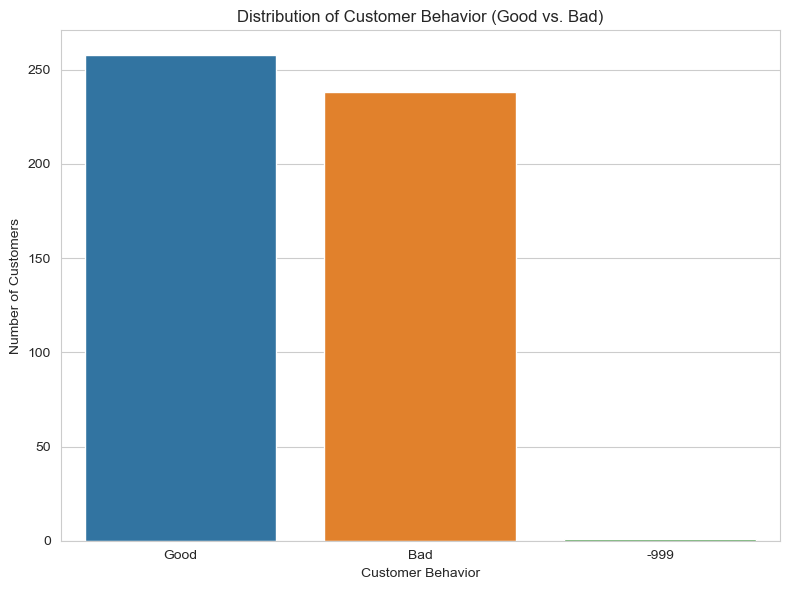

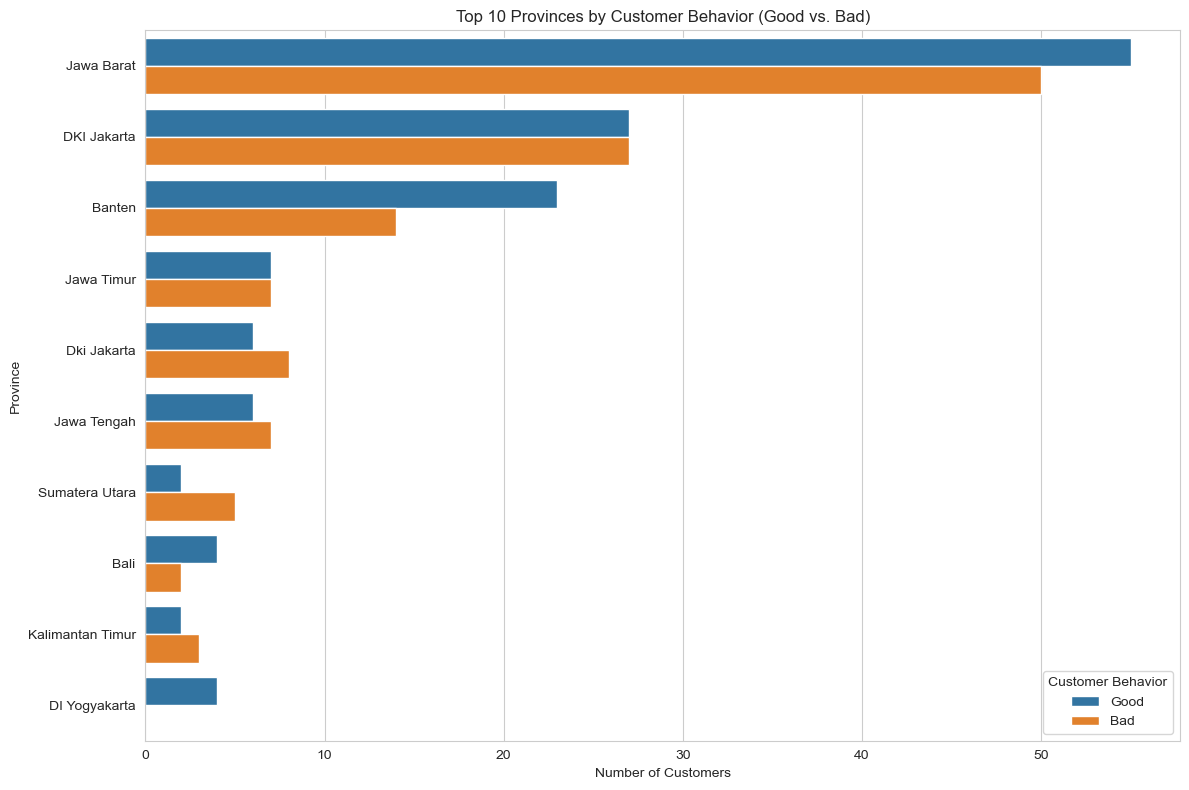

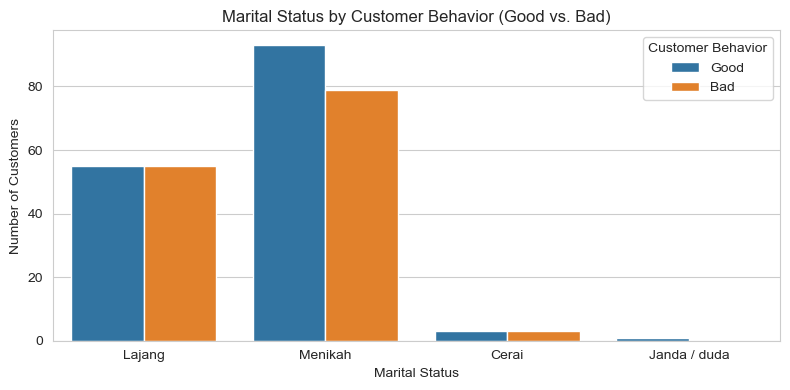

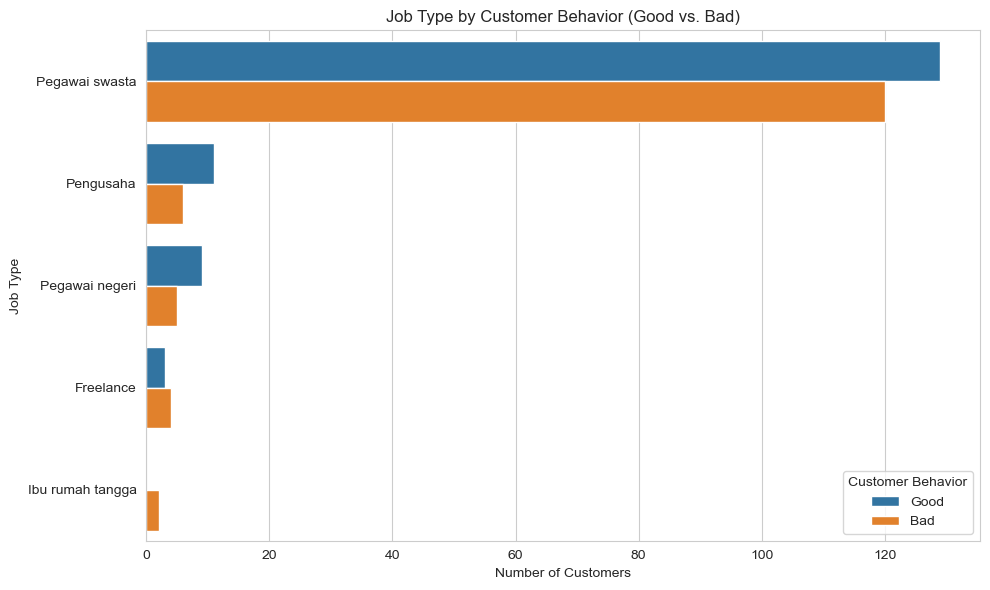

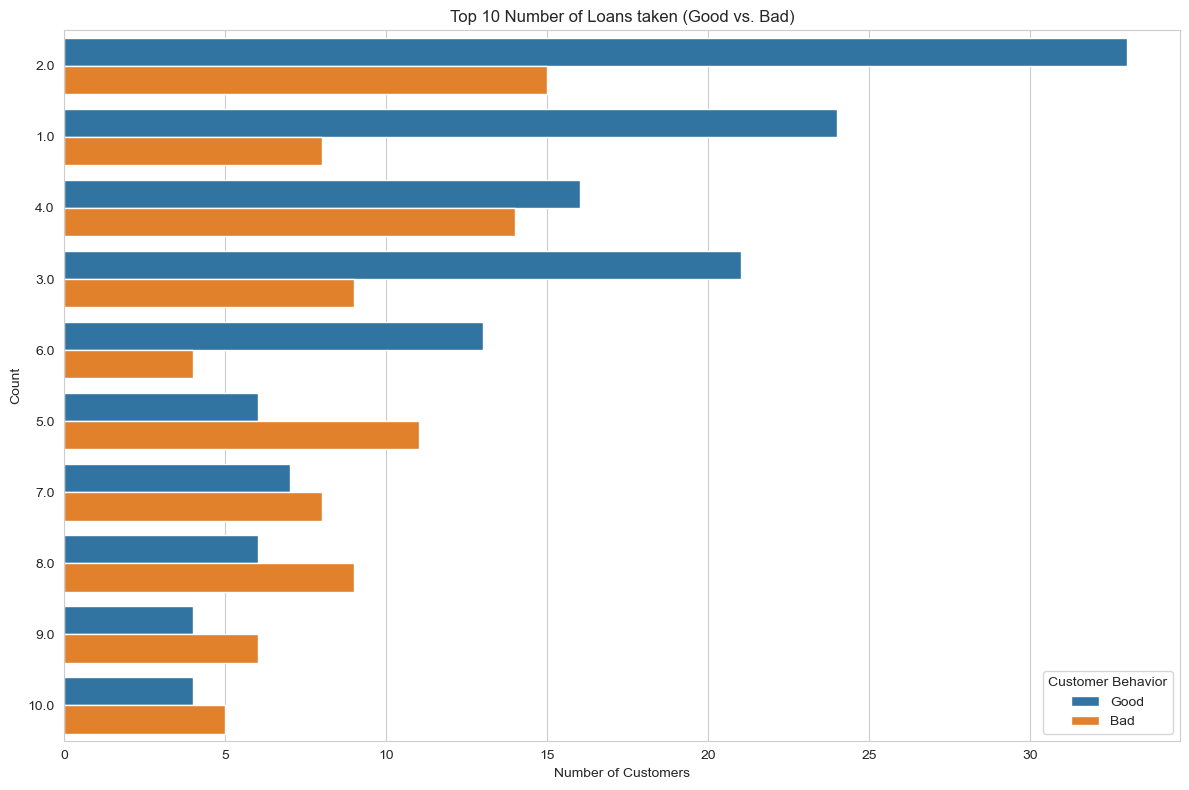

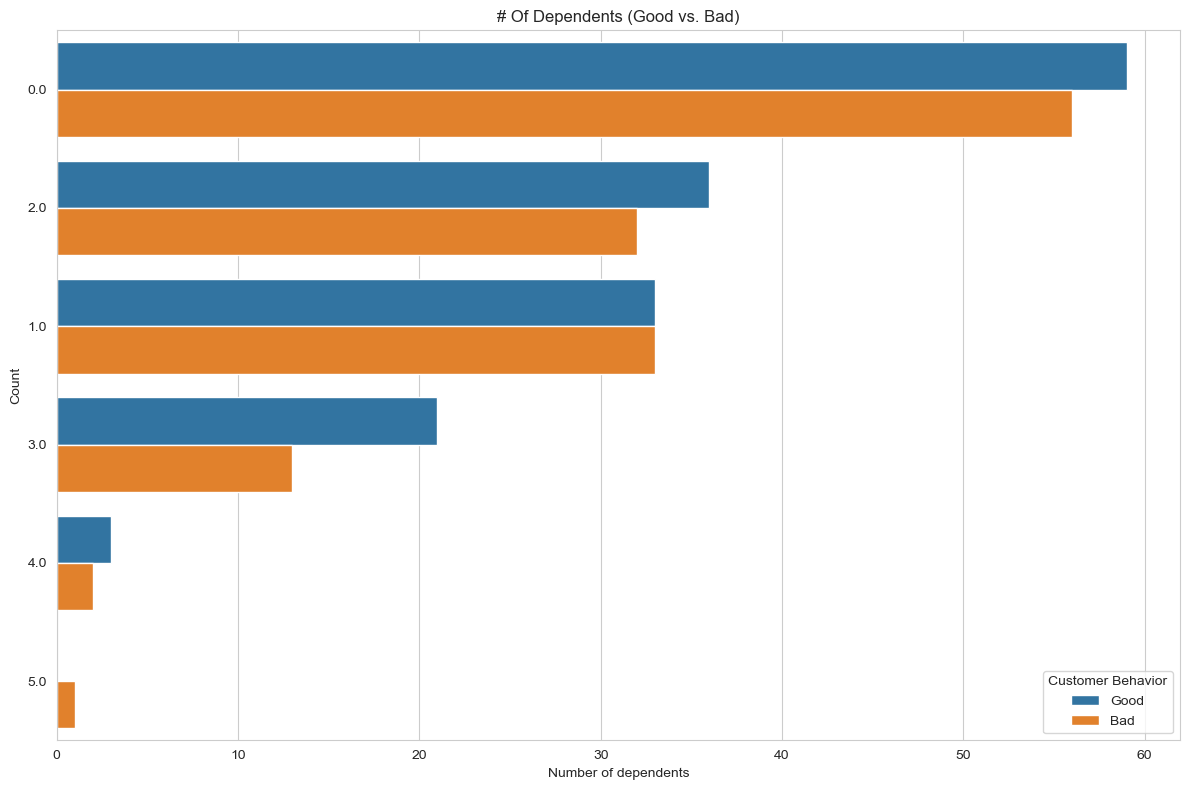

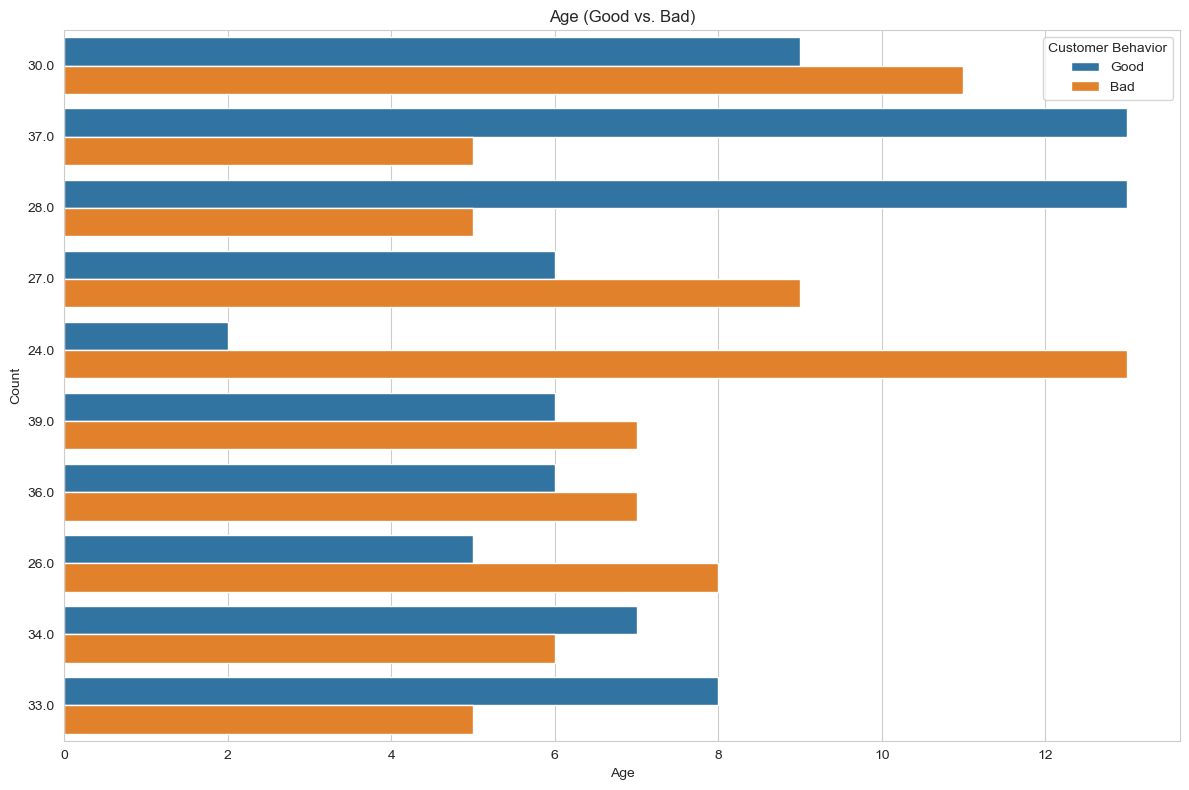

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Assuming 'data_vis' is your DataFrame and 'GBFlag_cus' contains the 'Good' or 'Bad' labels
plt.figure(figsize=(8, 6))
sns.countplot(x='GBFlag_cus', data=combined_data)
plt.title('Distribution of Customer Behavior (Good vs. Bad)')
plt.xlabel('Customer Behavior')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


# Filter out -999 values for visualization purposes
data_vis = combined_data.replace(-999, pd.NA).dropna(subset=['address_provinsi', 'marital_status', 'job_type', 'dependent', 'total_loans', 'Age'])

# Address Provinsi
plt.figure(figsize=(12, 8))
sns.countplot(y='address_provinsi', hue='GBFlag_cus', data=data_vis, order=data_vis['address_provinsi'].value_counts().iloc[:10].index)
plt.title('Top 10 Provinces by Customer Behavior (Good vs. Bad)')
plt.xlabel('Number of Customers')
plt.ylabel('Province')
plt.legend(title='Customer Behavior')
plt.tight_layout()
plt.show()

# Marital Status
plt.figure(figsize=(8, 4))
sns.countplot(x='marital_status', hue='GBFlag_cus', data=data_vis)
plt.title('Marital Status by Customer Behavior (Good vs. Bad)')
plt.xlabel('Marital Status')
plt.ylabel('Number of Customers')
plt.legend(title='Customer Behavior')
plt.tight_layout()
plt.show()

# Job Type
plt.figure(figsize=(10, 6))
sns.countplot(y='job_type', hue='GBFlag_cus', data=data_vis)
plt.title('Job Type by Customer Behavior (Good vs. Bad)')
plt.xlabel('Number of Customers')
plt.ylabel('Job Type')
plt.legend(title='Customer Behavior')
plt.tight_layout()
plt.show()

# Total Loan taken
plt.figure(figsize=(12, 8))
sns.countplot(y='total_loans', hue='GBFlag_cus', data=data_vis, order=data_vis['total_loans'].value_counts().iloc[:10].index)
plt.title('Top 10 Number of Loans taken (Good vs. Bad)')
plt.xlabel('Number of Customers')
plt.ylabel('Count')
plt.legend(title='Customer Behavior')
plt.tight_layout()
plt.show()

# Dependents
plt.figure(figsize=(12, 8))
sns.countplot(y='dependent', hue='GBFlag_cus', data=data_vis, order=data_vis['dependent'].value_counts().iloc[:10].index)
plt.title('# Of Dependents (Good vs. Bad)')
plt.xlabel('Number of dependents')
plt.ylabel('Count')
plt.legend(title='Customer Behavior')
plt.tight_layout()
plt.show()

# Age
plt.figure(figsize=(12, 8))
sns.countplot(y='Age', hue='GBFlag_cus', data=data_vis, order=data_vis['Age'].value_counts().iloc[:10].index)
plt.title('Age (Good vs. Bad)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Customer Behavior')
plt.tight_layout()
plt.show()

Trend shows the Loans have been skewed towards specific segments more hence we cant really say where the most risk is coming from specifically. Most of the Loans taken by customers from Jawa Barat Province, Married, Age 30 with No Dependents and have taken 2 loans atleast.

Most Bad loans coming from Age Band 24, We Can Deploy some Policy checks on Age bracket 20-24 


We will analyze more after Fine and Coarse Classing of each variable what are the trends 

### Loan Amount Decile 

In [19]:
# Assuming "Bad" in GBFlag_cus indicates a defaulted loan
combined_data['IsDefault'] = combined_data['GBFlag_cus'].apply(lambda x: 1 if x == 'Bad' else 0)

# Sort customers by loan amount in ascending order
data_sorted = combined_data.sort_values(by='loan_amount')

# Define deciles
data_sorted['Decile'] = pd.qcut(data_sorted['Avg_Loan_Amount'], 10, labels=False, duplicates='drop')

# Calculate metrics for each decile
decile_metrics = data_sorted.groupby('Decile').agg(
    Number_of_Loans=('application_id', 'count'),
    Number_of_Defaulted_Loans=('IsDefault', 'sum'),
    Min_Loan_Amount=('Avg_Loan_Amount', 'min'),
    Max_Loan_Amount=('Avg_Loan_Amount', 'max'),
    Avg_Loan_Amount=('Avg_Loan_Amount', 'mean')
).reset_index()

# Calculate default rate for each decile
decile_metrics['Default_Rate'] = decile_metrics['Number_of_Defaulted_Loans'] / decile_metrics['Number_of_Loans']

# Calculate cumulative default rate
decile_metrics['Cumulative_Default_Rate'] = decile_metrics['Number_of_Defaulted_Loans'].cumsum() / decile_metrics['Number_of_Loans'].cumsum()

# Adjust the metrics to reflect rounded integers for loan amounts and percentages for rates
decile_metrics['Min_Loan_Amount'] = decile_metrics['Min_Loan_Amount'].round().astype(int)
decile_metrics['Max_Loan_Amount'] = decile_metrics['Max_Loan_Amount'].round().astype(int)
decile_metrics['Avg_Loan_Amount'] = decile_metrics['Avg_Loan_Amount'].round().astype(int)
decile_metrics['Default_Rate'] = (decile_metrics['Default_Rate'] * 100).round(2)
decile_metrics['Cumulative_Default_Rate'] = (decile_metrics['Cumulative_Default_Rate'] * 100).round(2)
decile_metrics



,Decile,Number_of_Loans,Number_of_Defaulted_Loans,Min_Loan_Amount,Max_Loan_Amount,Avg_Loan_Amount,Default_Rate,Cumulative_Default_Rate
0,0,50,38,-999,247100,129401,76.00,76.00
1,1,66,41,248067,500000,411116,62.12,68.10
2,2,33,19,511497,632391,575269,57.58,65.77
3,3,50,34,637500,937500,781383,68.00,66.33
4,4,52,27,947382,1250000,1080130,51.92,63.35
5,5,47,21,1255556,1756477,1514619,44.68,60.40
6,6,50,18,1756546,2321429,2007887,36.00,56.90
7,7,50,24,2333333,3000000,2723680,48.00,55.78
8,8,49,11,3055556,4600000,3791343,22.45,52.13
9,9,50,5,4666667,18000000,7273333,10.00,47.89


Looks like we have more Bad Loans with Lower transactions or with Lower Ticket size